# Modelling and Evaluation

## Objectives

* Answer business requirement  - the stakeholder wishes to predict whether a lemon is of good or poor quality from a photograph.

## Inputs

* lemon-quality-dataset/lemon_dataset/train
* lemon-quality-dataset/lemon_dataset/validation
* lemon-quality-dataset/lemon_dataset/test
* Image shape embeddings

## Outputs

* Class indices for datasets
* TensorFlow machine learning model
* Hyperparameter optimisation pipeline
* Model trained on best hyperparameters
* Learning curve plot to evaluate model performance
* Model evaluation
* Confusion Matrix for Test Set




---

## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Change working directory

* We are assuming you will store the notebooks in a sub folder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/lemon-qualitycontrol/jupyter_notebooks'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/lemon-qualitycontrol'

### Set Input Directories

In [5]:
my_data_dir = 'inputs/lemon-quality-dataset/lemon_dataset'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v5'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir +
                                                                  '/outputs'):
    print(f'Old version is already available, create a new version'
          f'by changing version variable.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


Set labels

In [7]:
labels = os.listdir(train_path)

print(f"Project Labels: {labels}")

Project Labels: ['bad_quality', 'good_quality']


Set image shape

In [8]:
import joblib
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(100, 100, 3)

## Number of images in train, validation, and test sets

In [ ]:
def frequency_plots(folders: list):
    '''
    Plots bar and pie plots to display value counts of images in input folders.
    '''
    df_freq = pd.DataFrame([])
    df_total_freq = pd.DataFrame([])
    for folder in folders:
        for label in labels:
            df_freq = df_freq.append(
                      pd.Series(data={'Set': folder, 'Label': label,
                                      'Frequency': int(len(os.listdir(
                                                       my_data_dir + '/'
                                                       + folder + '/'
                                                       + label)))}),
                      ignore_index=True)
            print(f"* {folder} - {label}: "
                  f"{len(os.listdir(my_data_dir+'/' + folder + '/' + label))}"
                  f" images")
    print("\n")
    print(df_freq)
    for label in labels:
        df_query = df_freq.query(f'Label == "{label}"')
        df_total_freq = df_total_freq.append(
                        pd.Series(data={'Label': label,
                                        'Total': df_query['Frequency'].sum()}),
                        ignore_index=True)
    print(df_total_freq)
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', ax=ax1)
    ax2.pie(data=df_total_freq, x='Total', labels='Label', autopct='%.1f%%')
    plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', 
                dpi=150)
    plt.show()

* train - bad_quality: 1653 images
* train - good_quality: 811 images
* validation - bad_quality: 236 images
* validation - good_quality: 115 images
* test - bad_quality: 473 images
* test - good_quality: 233 images


   Frequency         Label         Set
0     1653.0   bad_quality       train
1      811.0  good_quality       train
2      236.0   bad_quality  validation
3      115.0  good_quality  validation
4      473.0   bad_quality        test
5      233.0  good_quality        test
          Label   Total
0   bad_quality  2362.0
1  good_quality  1159.0


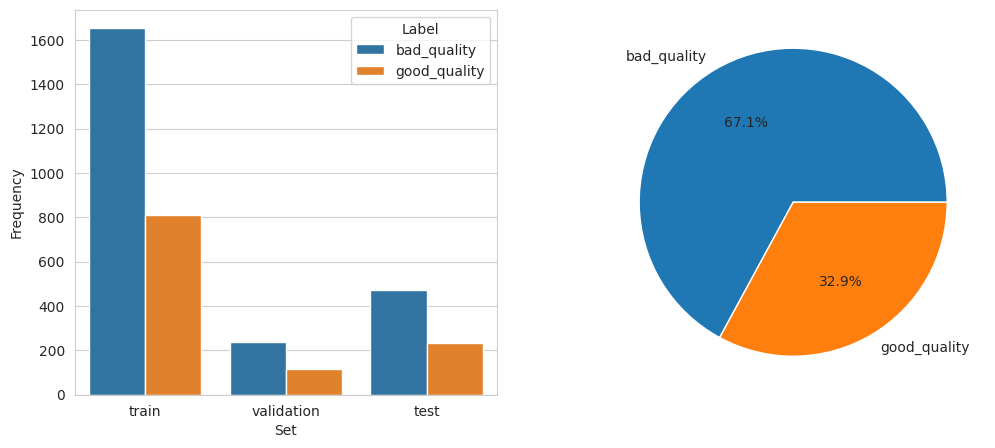

In [10]:
freq_plots = frequency_plots(folders = ['train', 'validation', 'test'])

## Image Data Augmentation

### Image Data Generator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialise image data generator and define parameters

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10, 
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255)

Augment training image dataset

In [13]:
batch_size = 20 
train_set = augmented_image_data.flow_from_directory(
                                            train_path,
                                            target_size=image_shape[:2],
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True)

train_set.class_indices

Found 2464 images belonging to 2 classes.


{'bad_quality': 0, 'good_quality': 1}

Augment validation image dataset

In [14]:
validation_set = ImageDataGenerator(
                        rescale=1./255).flow_from_directory(
                                                val_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                shuffle=False)

validation_set.class_indices

Found 351 images belonging to 2 classes.


{'bad_quality': 0, 'good_quality': 1}

Augment test image dataset

In [15]:
test_set = ImageDataGenerator(
                    rescale=1./255).flow_from_directory(
                                            test_path,
                                            target_size=image_shape[:2],
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=False)

test_set.class_indices

Found 706 images belonging to 2 classes.


{'bad_quality': 0, 'good_quality': 1}

---

## Plot Augmented training images

(20, 100, 100, 3)


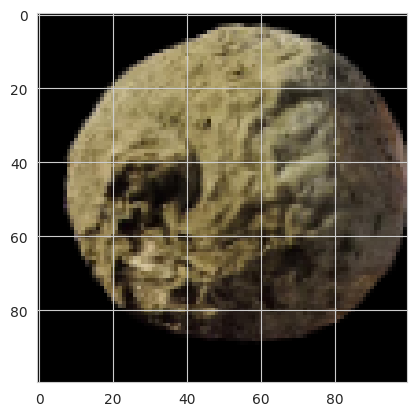

(20, 100, 100, 3)


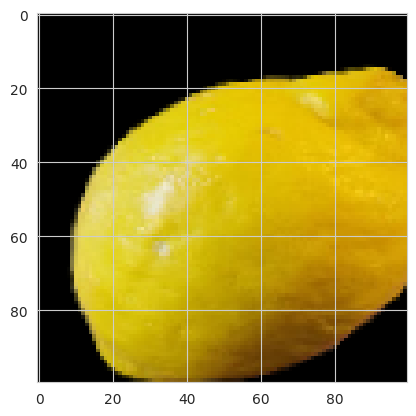

(20, 100, 100, 3)


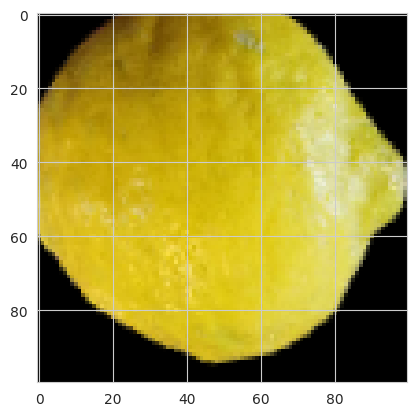

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot augmented validation images

(20, 100, 100, 3)


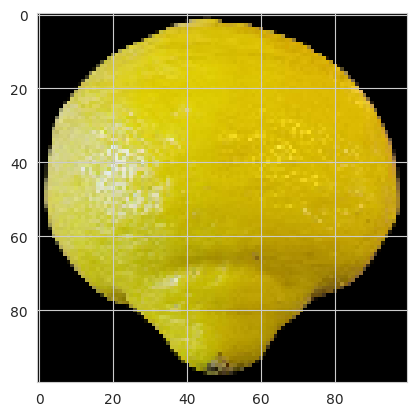

(20, 100, 100, 3)


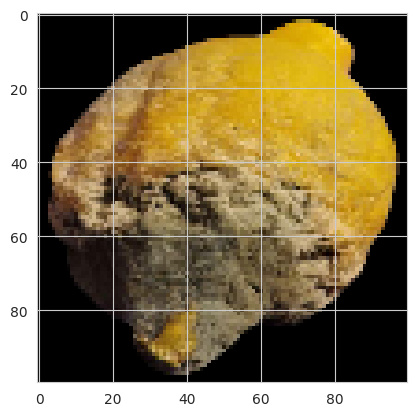

(20, 100, 100, 3)


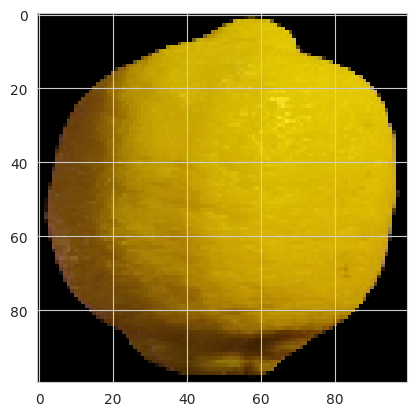

In [17]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot augmented test set images

(20, 100, 100, 3)


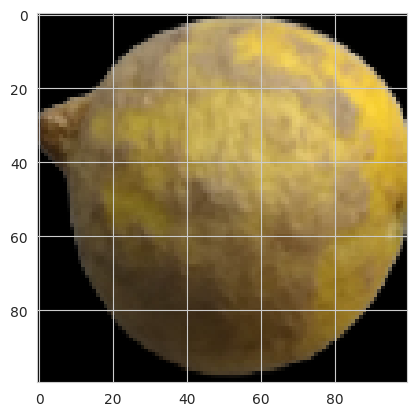

(20, 100, 100, 3)


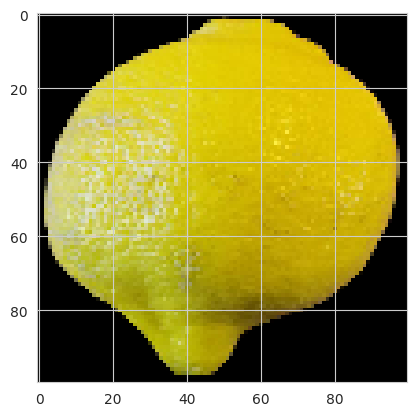

(20, 100, 100, 3)


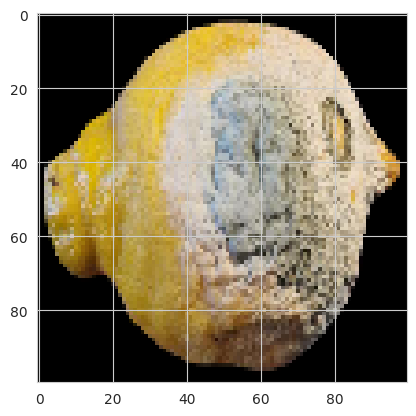

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Save class indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v5/class_indices.pkl']

---

## Model Creation

Import layers for model creation and tuner for hyperparameter optimisation

In [20]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Activation, Dropout, Flatten, Dense,
                                     Conv2D, MaxPooling2D)

Define hypermodel for hypertuning

In [22]:
def model_builder(hp):
    '''
    Builds models with varying hyperparameter configurations on which
    hyperparameter optimisation is run.
    '''
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape,
                     activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(Dense(units=hp_units, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    opt = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

Perform hyperparameter tuning - hyperband chosen as tuner for processing speed

In [23]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=file_path,
                     project_name='hypertuning'
                     )

2022-11-19 10:42:27.463147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import early stopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Calculate required class weight to handle target imbalance in data

In [25]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                      'balanced',
                      np.unique(train_set.classes),
                      train_set.classes)

train_class_weights = dict(enumerate(class_weights))
train_class_weights

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.7453115547489413, 1: 1.5191122071516645}

Perform tuner search

In [26]:
tuner.search(train_set,
             epochs=25,
             steps_per_epoch=len(train_set.classes) // batch_size,
             validation_data=validation_set,
             class_weight=train_class_weights,
             callbacks=[early_stop],
             verbose=2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the
first densely-connected layer is {best_hps.get('units')} and the optimal
learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 21 Complete [00h 01m 49s]
val_accuracy: 0.945868968963623

Best val_accuracy So Far: 0.9743589758872986
Total elapsed time: 00h 24m 01s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128 and the optimal learning rate for the optimizer
is 0.001.



Create model using defined best hyperparameters

In [27]:
model = tuner.hypermodel.build(best_hps)

Print model summary and shape displaying number of trainable parameters

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)             

Fit model with best hyperparameters to train set

In [29]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          class_weight=train_class_weights,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
123/123 [==============================] - 29s 228ms/step - loss: 0.5631 - accuracy: 0.7005 - val_loss: 0.3056 - val_accuracy: 0.8689
Epoch 2/25
123/123 [==============================] - 31s 250ms/step - loss: 0.3814 - accuracy: 0.8392 - val_loss: 0.2271 - val_accuracy: 0.9117
Epoch 3/25
123/123 [==============================] - 23s 187ms/step - loss: 0.2695 - accuracy: 0.9071 - val_loss: 0.1830 - val_accuracy: 0.9430
Epoch 4/25
123/123 [==============================] - 23s 186ms/step - loss: 0.2359 - accuracy: 0.9214 - val_loss: 0.1304 - val_accuracy: 0.9658
Epoch 5/25
123/123 [==============================] - 23s 185ms/step - loss: 0.1882 - accuracy: 0.9444 - val_loss: 0.1313 - val_accuracy: 0.9601
Epoch 6/25
123/123 [==============================] - 27s 221ms/step - loss: 0.1866 - accuracy: 0.9431 - val_loss: 0.2179 - val_accuracy: 0.9174
Epoch 7/25
123/123 [==============================] - 30s 241ms/step - loss: 0.1980 - accuracy: 0.9394 - val_loss: 0.1368 - val_ac

Save model

In [30]:
model.save(f'outputs/{version}/lemon_quality_model.h5')

### Model Performance

Model learning curve

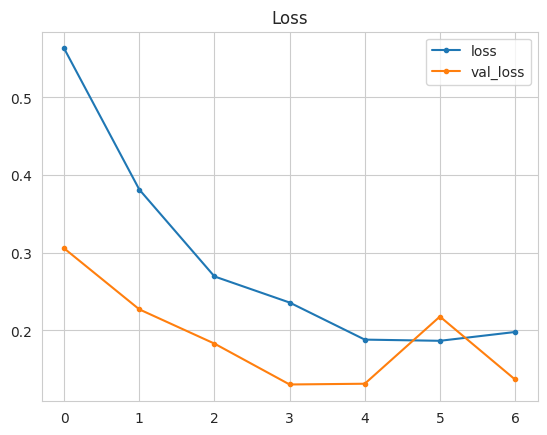

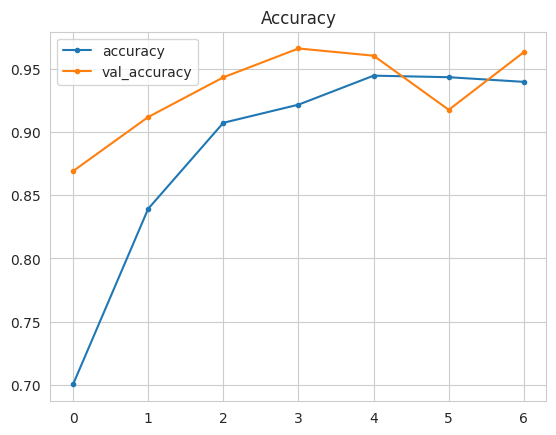

In [31]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight',
            dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight',
            dpi=150)
plt.show()

### Model Evaluation

Load saved model

In [32]:
from keras.models import load_model
model = load_model(f'outputs/{version}/lemon_quality_model.h5')

Evaluate saved model on test set

In [33]:
evaluation = model.evaluate(test_set)

36/36 [==============================] - 5s 145ms/step - loss: 0.1150 - accuracy: 0.9646


Save evaluation pickle

In [34]:
joblib.dump(value=evaluation ,
            filename=f"outputs/{version}/evaluation.pkl")

['outputs/v5/evaluation.pkl']

## Confusion Matrix

Print classification report and confusion matrix

              precision    recall  f1-score   support

 Bad Quality       0.97      0.98      0.97       473
Good Quality       0.95      0.94      0.95       233

    accuracy                           0.96       706
   macro avg       0.96      0.96      0.96       706
weighted avg       0.96      0.96      0.96       706



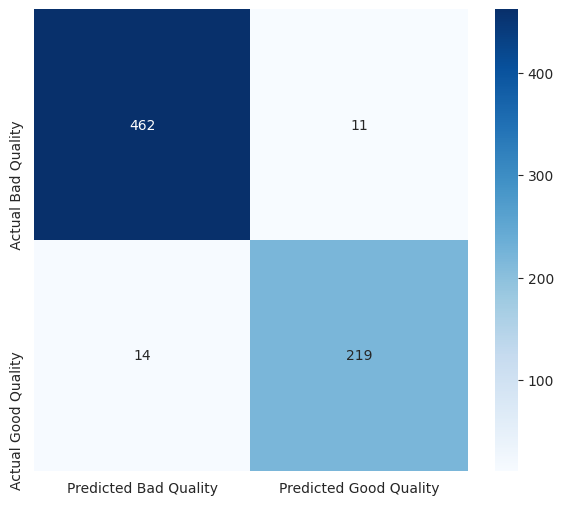

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
pred = model.predict(test_set)
y_pred = np.concatenate(np.round(pred).astype(int))
target_names = ['Bad Quality', 'Good Quality']
confusion_matrix = confusion_matrix(test_set.classes, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=['Predicted Bad Quality', 'Predicted Good Quality'],
            yticklabels=[' Actual Bad Quality', 'Actual Good Quality'],)
plt.savefig(f'{file_path}/confusion_matrix.png', bbox_inches='tight', dpi=150)
print(classification_report(test_set.classes, y_pred, 
      target_names=target_names))

## Predict on new data

Load random image

Image shape: (100, 100), Image mode: RGB


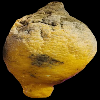

In [36]:
from tensorflow.keras.preprocessing import image

pointer = 49
label = labels[0]

pil_image = image.load_img(test_path + '/' + label + '/' +
                           os.listdir(test_path + '/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [37]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


Predict class probabilities

In [38]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9998582303524017
bad_quality
